In [1]:
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import PIL.Image as Image
import sys
sys.path.append('../src/')

# import custom python modules
from data.config import * 
import data.data_utils as du
import models.model_utils as mu
import processing.processing_utils as pu
from models.models import UNet128 as Net

In [2]:
# arguments
batch_size = 4
n_epochs = 1

In [3]:
# Transforms to be applied on input data
base_tsfm = transforms.Compose([transforms.Scale(128),
                                transforms.CenterCrop(128),
                                transforms.ToTensor()])

# Datasets
train_dataset = du.CarvanaDataset('../data/raw/train', '../data/raw/train_masks/',
                                  common_transforms=base_tsfm, debug=True)
test_dataset = du.CarvanaDataset('../data/raw/test',
                                 input_transforms=base_tsfm, debug=True)

# DataLoaders
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=3)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=3)

In [4]:
# Model
net = Net()
# net.cuda()

In [5]:
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# Loss 
def criterion(logits, labels):
    """Define loss function to be used. Can be a mix of losses defined in model_utils module."""
    l = mu.BCELoss2d()(logits, labels) + mu.DiceLoss()(logits, labels)
    return l

In [6]:
# Training loop

from tqdm import tqdm 

loss_history = []

for epoch in tqdm(range(n_epochs)):

    for i, im in enumerate(tqdm(train_loader)):
        images = Variable(im['image'])
        masks_gt = Variable(im['mask'])
        
        # forward pass
        masks_pred = net.train()(images)
    
        # backward pass
        loss = criterion(masks_pred, masks_gt)
        optimizer.zero_grad() # set all gradients to zero
        loss.backward() # backpropagate
        optimizer.step() # do update step
        
        if i % 1 == 0:
            loss_history.append(loss.data.numpy()[0])    

100%|██████████| 1/1 [00:20<00:00, 20.96s/it]


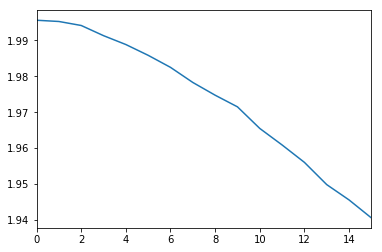

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd 
fig, ax = plt.subplots()
pd.Series(loss_history).plot(ax=ax)

In [8]:
# Make predictions for test data
test_idx = []
rle_encoded_predictions = []

for i, im in enumerate(tqdm(test_loader)):
    images = Variable(im['image'])
    masks_test = net.eval()(images)
     
    # Go from pytorch tensor to list of PIL images, which can be rescaled and interpolated
    PIL_list = [transforms.ToPILImage()(masks_test.data[b]) for b in range(masks_test.size()[0])]

    # Rescale them to np matrices with the correct size
    np_list = [pu.upscale_test_img(img) for img in PIL_list]
        
    # rle encode the predictions
    rle_encoded_predictions.append([pu.rle(im)[2] for im in np_list])
    test_idx.append(im['id'])


# Prepare submission file
test_idx_all = [j+'.jpg' for batch in test_idx for j in batch] 
rle_encoded_predictions_all = [j for batch in rle_encoded_predictions for j in batch]
predictions_mapping = dict(zip(test_idx_all, rle_encoded_predictions_all))

# Map predictions to the sample submission file to make sure we make no errors with the ordering of files
submission_file = pd.read_csv(SAMPLE_SUB_CSV)
submission_file['rle_mask'] = submission_file['img']
submission_file['rle_mask'] = submission_file['rle_mask'].map(predictions_mapping)

print('Done!')

100%|██████████| 16/16 [00:09<00:00,  1.97it/s]

Done!


In [31]:
predictions_mapping

{'0179cf3ecd9f_03.jpg': '',
 '072bfd926afb_16.jpg': '',
 '07bcb1717ce1_13.jpg': '',
 '0d6817a96229_05.jpg': '',
 '127ac0749d0a_08.jpg': '',
 '13e793314d22_12.jpg': '',
 '159347bd6cd2_10.jpg': '',
 '174de590731e_14.jpg': '',
 '238b3435e159_09.jpg': '',
 '241c4ec21800_01.jpg': '',
 '25782cd95cca_07.jpg': '',
 '28ef78b941ee_11.jpg': '',
 '2943765d1edc_12.jpg': '',
 '2ac699eaa74e_10.jpg': '',
 '2b103ba71da4_08.jpg': '',
 '2e8024a81a2f_10.jpg': '',
 '3647b9225824_04.jpg': '',
 '3c6912ef1306_05.jpg': '',
 '47467e211acc_04.jpg': '',
 '49ac4838a0d8_10.jpg': '',
 '4be9af3c17d4_03.jpg': '',
 '5e25d181e30d_13.jpg': '',
 '61f59df35e2f_01.jpg': '',
 '654c8211d2be_06.jpg': '',
 '656642c77480_16.jpg': '',
 '6ac3ae4c389f_10.jpg': '',
 '72817de2a74e_09.jpg': '',
 '774a9c35c166_10.jpg': '',
 '813f09839ae9_13.jpg': '',
 '816bf017d0eb_03.jpg': '',
 '82b64cbc77ba_01.jpg': '',
 '8353838b4a06_10.jpg': '',
 '8805098f7977_16.jpg': '',
 '889a705936ed_09.jpg': '',
 '8925cf8720ef_03.jpg': '',
 '8acb6f546dc3_05.jp

,img,rle_mask
0,0004d4463b50_01.jpg,NaN
1,0004d4463b50_02.jpg,NaN
2,0004d4463b50_03.jpg,NaN
3,0004d4463b50_04.jpg,NaN
4,0004d4463b50_05.jpg,NaN
